# Deep learning for time-series - Assignment 1
The notebook is structured such that
- a sub task is stated,
- the associated code for answering follows,
- any comments follows the code.

Some sub tasks will for efficiency or context be merged.

Some main tasks will include a summary in the end if needed.

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

## Part A

In [281]:
# Load data
df_raw = pd.read_csv("www_usage.csv")

### A1. Exploratory analysis
- Plot $y_t$ over time (clear labels). Describe trend/level changes/outliers.
- Add a simple smoothing overlay (moving average or exponential smoothing) only to highlight
structure (do not use it as the final model).

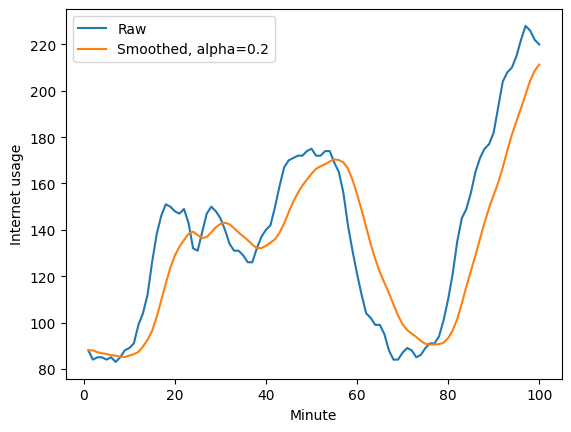

In [282]:
df = df_raw.copy()

# Fit exponential smoothing
model = SimpleExpSmoothing(df.y)
alpha = 0.2
fit = model.fit(smoothing_level=alpha, optimized=False)
y_smooth = fit.fittedvalues

# Plot raw and smoothed series
plt.plot(df.ds, df.y, label="Raw")
plt.plot(df.ds, y_smooth, label=f"Smoothed, alpha={alpha}")
plt.xlabel("Minute")
plt.ylabel("Internet usage")
plt.legend()
plt.show()

The series seems to display transient trends or level changes over time which makes it non-stationary in both a strict and weak sense. There seems to be some noise making the series jitter around a mean. It is difficult to ascertain if there are outliers or if the series is heteroskedastic since the levels change so much.

### A2. Select the differencing order $d$
- Test $d=0, 1, 2$ in order. For each candidate: plot the differenced series and its ACF.

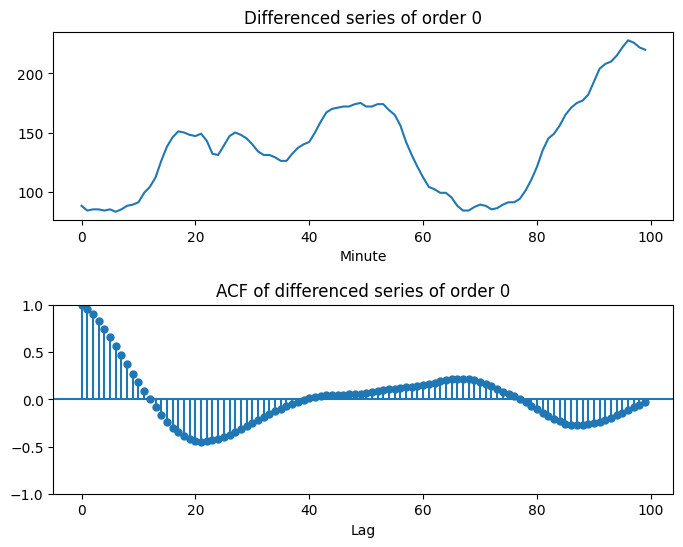

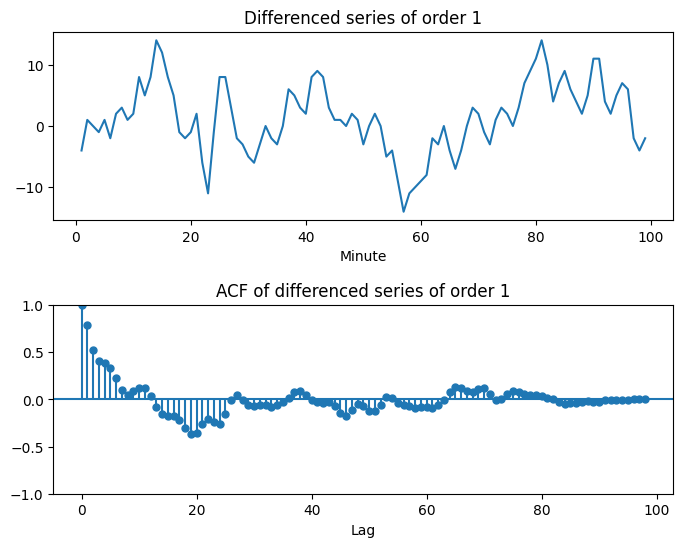

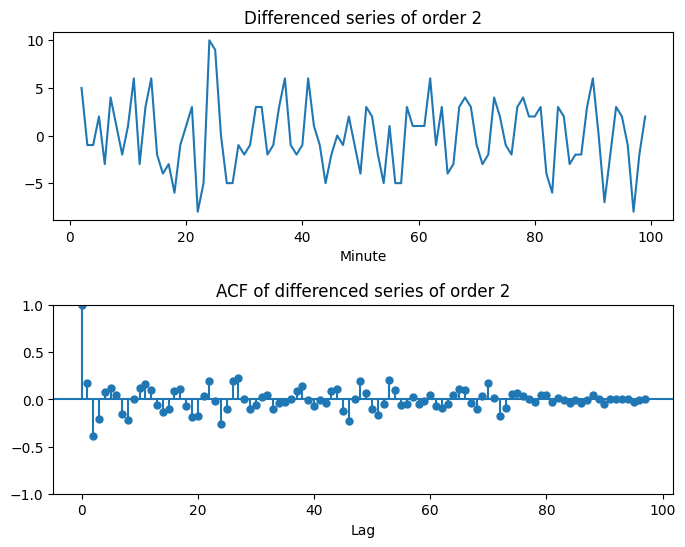

In [291]:
# Calculate differenced series
series = {}
series["0"] = df.y
series["1"] = df.y.diff().dropna()
series["2"] = series["1"].diff().dropna()

# Plot differenced series and corresponding sample ACFs
for key, value in series.items():
    fig, ax = plt.subplots(
        2, 1,
        figsize=(8,6),
        gridspec_kw={"hspace": 0.45}
    )
    ax[0].plot(value)
    ax[0].set_title("Differenced series of order "+str(key))
    ax[0].set_xlabel("Minute")

    plot_acf(value, lags=len(value)-1, ax=ax[1], alpha=None)
    ax[1].set_xlabel("Lag")
    ax[1].set_title("ACF of differenced series of order "+str(key))

- Run stationarity tests: ADF (null: unit root / nonstationary) and KPSS (null: stationary).

In [284]:
def stationarity_tests(series, name=""):
    # Applies ADF and KPSS tests

    # Ignore warnings on non-representative p-values
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        adf_stat, adf_p, *_ = adfuller(series)
        kpss_stat, kpss_p, *_ = kpss(series)

    return {
        "series": name,
        "adf_stat": adf_stat,
        "adf_p": adf_p,
        "kpss_stat": kpss_stat,
        "kpss_p": kpss_p
    }


results = []
for key, value in series.items():
    results.append(stationarity_tests(value, "Diff order "+key))
results = pd.DataFrame(results)

results

,series,adf_stat,adf_p,kpss_stat,kpss_p
0,Diff order 0,-2.464240,1.244194e-01,0.389007,0.081894
1,Diff order 1,-2.722238,7.026846e-02,0.167290,0.100000
2,Diff order 2,-9.929762,2.843429e-17,0.074949,0.100000



- Choose the smallest $d$ that makes the series look stationary and passes tests reasonably (avoid
over-differencing).
- Write 3–6 sentences explaining why your chosen d is appropriate.

The plots of the ACFs show significant correlations lags larger than 0 for the 0th- and 1st-order differenced series while the 2nd-order differenced series shows low autocorrelation for lags larger than 0.

The ADF test rejects the null hypothesis of a unit root at a 95% significance level for the 2nd-order differenced series while it does not for the 0th- and 1st-order differenced series. This suggests stationarity for the 2nd-order differenced series. The statistic for the 1st-order differenced series is however close to the significance threshold.

The KPSS does not reject the null hypothesis at a 95% significance level for any of the series but the p-values might be inflated from few samples.

From visual inspection of the plots of the time series and the ACFs in conjunction with the ADF and KPSS test a differencing order of $d=1$ is chosen. An order of 2 is not chosen in order to avoid over differencing and removing dependency between samples for the autoregressive part of the model to properly work.

### A3. Select $p$ and $q$ (AR and MA orders)
- Using the series after differencing with your chosen $d$, plot ACF and PACF (choose a sensible number of lags).

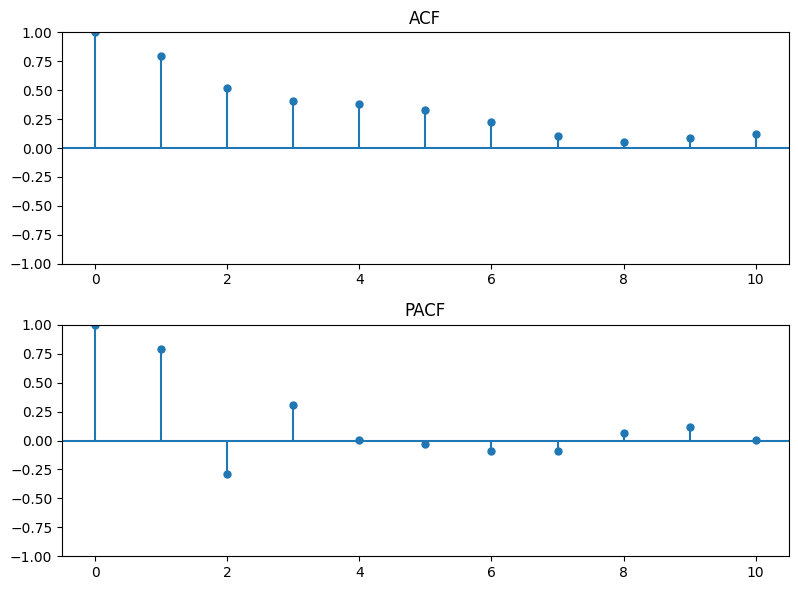

In [292]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
lags = 10
plot_acf(series["1"], lags=lags, ax=ax[0], alpha=None)
ax[0].set_title("ACF")
plot_pacf(series["1"], lags=lags, ax=ax[1], alpha=None)
ax[1].set_title("PACF")
plt.tight_layout()
plt.show()

- Propose a small set of candidate $(p, q)$ values based on ACF/PACF patterns (e.g., p up to 6, q up
to 4).
- Fit a grid of ARIMA($p$, $d$, $q$) models for those candidates and compare AIC and BIC.

In [286]:
p_values = range(0, 4)  # AR orders
d = 1
q_values = range(0, 5)  # MA orders

results = []

warnings.filterwarnings("ignore")  # suppress convergence warnings

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(df.y, order=(p, d, q))
            model_fit = model.fit()
            results.append({
                'p': p,
                'd': d,
                'q': q,
                'AIC': model_fit.aic,
                'BIC': model_fit.bic
            })
        except:
            continue

results_df = pd.DataFrame(results)

# Sort by BIC
results_df = results_df.sort_values('BIC').reset_index(drop=True)
results_df.head(5)

,p,d,q,AIC,BIC
0,1,1,1,514.300254,522.085614
1,3,1,0,511.994816,522.375295
2,1,1,2,516.252648,526.633128
3,2,1,1,516.292220,526.672700
4,3,1,1,513.938500,526.914099


- Pick a final model using a parsimony rule: prefer the simplest model with competitive BIC and
good diagnostics.

Based upon the low AIC, BIC, simplicity and the fact that the ACF tapers of indicating no need for a moving average part a final model of ($3, 1, 0$) is picked.

### A4. Estimate parameters (MLE) and interpret
- Fit the selected ARIMA model using statsmodels. Report parameter estimates and standard
errors.

In [287]:
orders = (3, 1, 0)
model = ARIMA(df.y, order=orders)
model_fit = model.fit()

results = pd.DataFrame({
    "estimate": model_fit.params,
    "std_error": model_fit.bse
})

results

,estimate,std_error
ar.L1,1.151339,0.102672
ar.L2,-0.661223,0.134078
ar.L3,0.340715,0.093584
sigma2,9.363309,1.368681


- Explain in simple terms what maximum likelihood estimation is doing for ARIMA. (You may
mention that statsmodels evaluates the likelihood via a state-space/Kalman filter implementation.)

MLE is used for parameter estimation in ARIMA models and the parameters are estimated under the assumption that the residuals are normally distributed. The likelihood function with this distribution can then be maximised with respect to the parameters and according to the observed data.

The Kalman filter is used for efficient computation since the ARIMA model can be represented as a state-space model where the recursive moving average part is implicitely included in the state-space representation and where the noise is Gaussian. The Kalman filter is suitable because of the assumption of normally distributed noise in the state-space model.

For this particular choice of model parameters (moving average order of 0) the Kalman filter is not needed for efficient estimation. OLS or Yule-Walker could then be used for efficient estimation.

### A5. Residual diagnostics (white-noise check)
- Plot residuals and residual ACF.

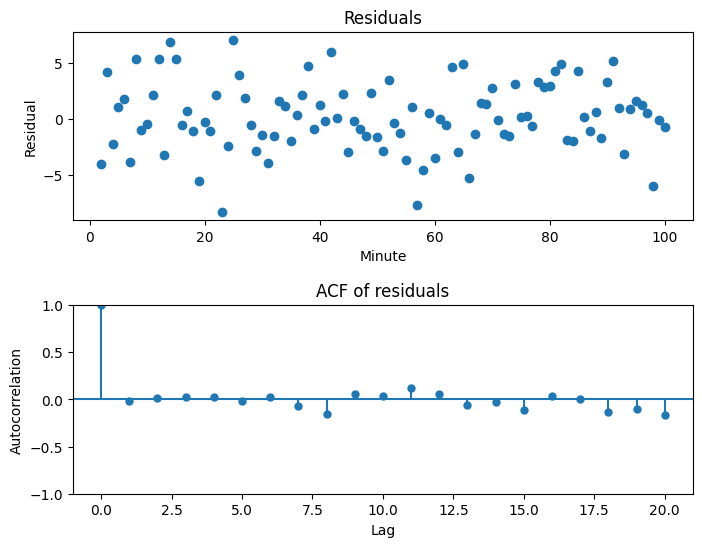

In [293]:
resid = model_fit.resid[1:]

fig, ax = plt.subplots(
    2, 1,
    figsize=(8,6),
    gridspec_kw={"hspace": 0.45}
)

ax[0].scatter(df.ds[1:], resid)
ax[0].set_title("Residuals")
ax[0].set_xlabel("Minute")
ax[0].set_ylabel("Residual")

plot_acf(resid, ax=ax[1], alpha=None)
ax[1].set_title("ACF of residuals")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Autocorrelation")

plt.show()


- Run Ljung–Box at several lags (e.g., 10 and 20) and interpret the p-values.
- If residuals are not white noise, describe one concrete model revision (change p/q, revisit d, etc.)
and justify.


In [289]:
# Ljung-Box test for lags 10 and 20
lb_test = acorr_ljungbox(resid, lags=20)
lb_test.loc[[10, 20]]

,lb_stat,lb_pvalue
10,3.956673,0.949280
20,14.861316,0.784287


The residuals seem from visual inspection to be uncorrelated in time, the ACF indicated small autocorrelation for lags larger than 0 and the Ljung-Box test does not reject the null-hypothesis of no correlation at a 95% significance level. The residuals therefore resemble white noise and the assumed noise in the model. They do therefore not provide motivation for changing the model radically.

### A6. Forecasting validation (hold-out)
- Hold out the last h = 20 observations as a test set. Fit your ARIMA model on the remaining data.

In [180]:
# Divide into train and test sets
h = 20
train = df.y[:-h]
test  = df.y[-h:]

# Fit ARIMA
model = ARIMA(train, order=orders)
fitted = model.fit()


- Forecast h steps ahead with 95% prediction intervals. Plot train/test/forecast clearly.

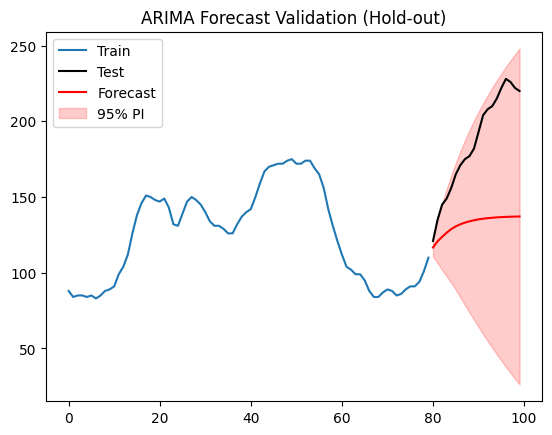

In [181]:
forecast_res = fitted.get_forecast(steps=h)

forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int(alpha=0.05)

plt.plot(train, label="Train")
plt.plot(test, label="Test", color="black")
plt.plot(forecast, label="Forecast", color="red")

plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color="red",
    alpha=0.2,
    label="95% PI"
)

plt.legend()
plt.title("ARIMA Forecast Validation (Hold-out)")
plt.show()

- Compute MAE and RMSE on the test set.
- Compare against a naive baseline (repeat the last training value) and briefly interpret the results

In [ ]:
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast)

naive_forecast = np.repeat(train.iloc[-1], h)
naive_mae = mean_absolute_error(test, naive_forecast)
naive_rmse = mean_squared_error(test, naive_forecast)

print(f"ARIMA MAE  = {mae:.3f}")
print(f"ARIMA RMSE = {rmse:.3f}")

print(f"Naive MAE  = {naive_mae:.3f}")
print(f"Naive RMSE = {naive_rmse:.3f}")

ARIMA MAE  = 53.928
ARIMA RMSE = 3640.395
Naive MAE  = 76.200
Naive RMSE = 6858.700


The ARIMA model fails to capture the whole trend in the hold out set. This is expected since forecasts of an ARIMA($p$, 1, 0) flatten out over time. The model would need exogenous variables or more data to better understand the irregular behaviour of the time series and justify a more complex model.

The fitted ARIMA model performs better than the naive baseline since the naive baseline does not take a trend into account. It therefore does not even slightly continue the upward trend seen in the end of the training set.

## Part B

In [182]:
# Load data
df_raw = pd.read_csv("us_change.csv")

### B1. OLS baseline + diagnose residual autocorrelation
- Fit OLS: $y_t = c + β x_t + e_t$ ($y$ = consumption growth, $x$ = income growth).
- Report $\beta$, standard error, and Durbin–Watson statistic.

In [258]:
df = df_raw.copy()
x_name = "Income"
y_name = "y"

x = df[x_name]
y = df[y_name]

X = sm.add_constant(x)   # add intercept
ols_model = sm.OLS(y, X).fit()

beta = ols_model.params[x_name]
beta_se = ols_model.bse[x_name]
dw = sm.stats.stattools.durbin_watson(ols_model.resid)

print(f"β estimate    = {beta:.4f}")
print(f"Std. error    = {beta_se:.4f}")
print(f"Durbin–Watson = {dw:.3f}")

β estimate    = 0.2718
Std. error    = 0.0467
Durbin–Watson = 1.734


- Plot the residual ACF and run Ljung–Box. State whether residuals are autocorrelated.

<Figure size 640x480 with 0 Axes>

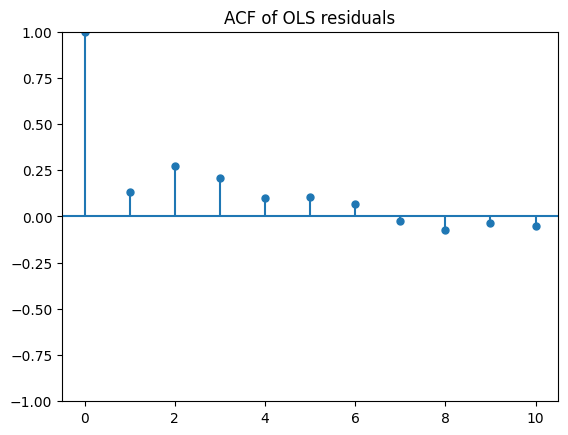

,lb_stat,lb_pvalue
10,35.077539,0.000121
20,40.987647,0.003739


In [294]:
plt.figure()
plot_acf(ols_model.resid, lags=10, alpha=None)
plt.title("ACF of OLS residuals")
plt.show()

lb = acorr_ljungbox(ols_model.resid, lags=[10, 20], return_df=True)
lb


The Durbin-Watson statistic is less than 2 indicating positive autocorrelation in the residuals.

The ACF shows that the residuals exhibit slight positive autocorrelation at lags larger than 0.

The Ljung-Box test reject the null hypothesis of no autocorrelation at a 95% significance level at lags 10 and 20.

Conclusion: the residuals are autocorrelated.

### B2. Choose an ARMA structure for the errors
- Use residual ACF and PACF to propose candidate ARMA($p$, $q$) orders for $e_t$ (start small).

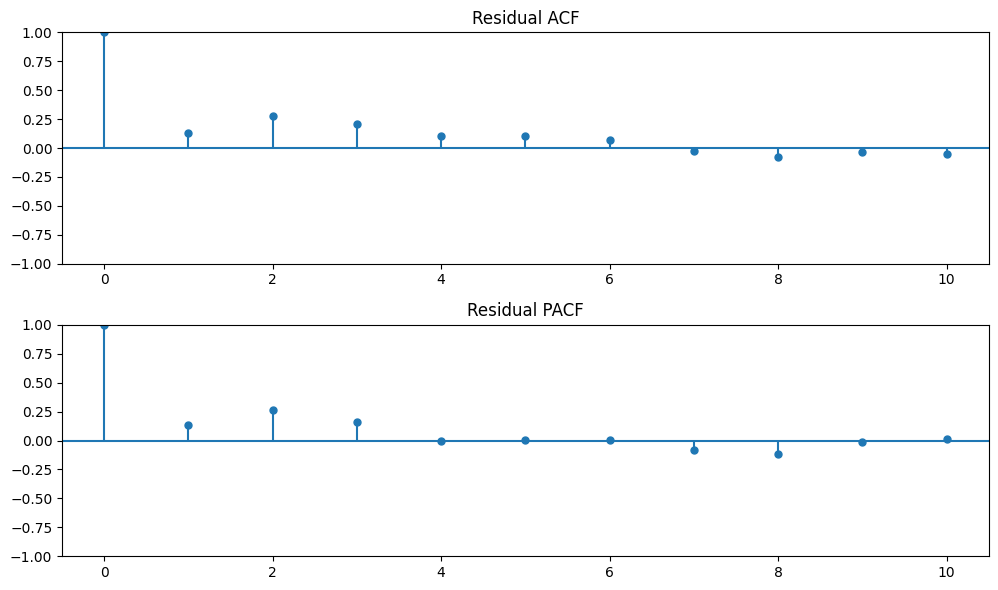

In [295]:
resid = ols_model.resid

fig, ax = plt.subplots(2, 1, figsize=(10,6))
lags = 10
plot_acf(resid, lags=lags, ax=ax[0], alpha=None)
ax[0].set_title("Residual ACF")
plot_pacf(resid, lags=lags, ax=ax[1], alpha=None)
ax[1].set_title("Residual PACF")

plt.tight_layout()
plt.show()

Based upon visual inspection of the drop off of the ACF and PACF plots the range [0; 3] is chosen for candidate orders for both $p$ and $q$.

- Fit a small grid of SARIMAX($y$, exog=$x$, order=($p$, 0, $q$), trend='c') models and compare BIC.
- Select a final ($p$, $q$) based on BIC + parsimony + residual whiteness.

In [265]:
p_vals = range(0, 4)
q_vals = range(0, 4)

results = []

warnings.filterwarnings("ignore")  # suppress convergence warnings

for p in p_vals:
    for q in q_vals:
        model = SARIMAX(
            y,
            exog=x,
            order=(p, 0, q),
            trend="c",
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        results.append({
            "p": p,
            "q": q,
            "AIC": res.aic,
            "BIC": res.bic
        })

results_df = pd.DataFrame(results).sort_values("BIC")
results_df.head(5)


,p,q,AIC,BIC
12,3,0,334.755602,354.393599
6,1,2,335.665357,355.303354
3,0,3,335.806323,355.413472
8,2,0,340.034855,356.425429
9,2,1,337.786476,357.455164


Orders $p=1$ and $q=2$ are chosen for simplicity and low AIC and BIC scores. Below is seen the whiteness of the residuals for the final fitted model.

The ACF of the residuals of the fitted model are on visual inspection white and fall within the 95% confidence interval.

### B3. Fit the final regression-with-ARMA-errors model
- Fit SARIMAX with your chosen ($p$, $q$). Report $\beta$ and the AR/MA parameters (with $p$-values).

In [266]:
final_model = SARIMAX(
    y,
    exog=x,
    order=(1, 0, 2),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

params = pd.DataFrame({
    "estimate": final_model.params,
    "p_value": final_model.pvalues
})

params

,estimate,p_value
intercept,0.181179,4.344784e-03
Income,0.199226,5.853009e-09
ar.L1,0.700232,7.066127e-11
ma.L1,-0.611770,9.516460e-08
ma.L2,0.210617,1.219782e-03
sigma2,0.307265,1.464737e-40


- Run residual/innovation diagnostics (ACF + Ljung–Box) to confirm whiteness.

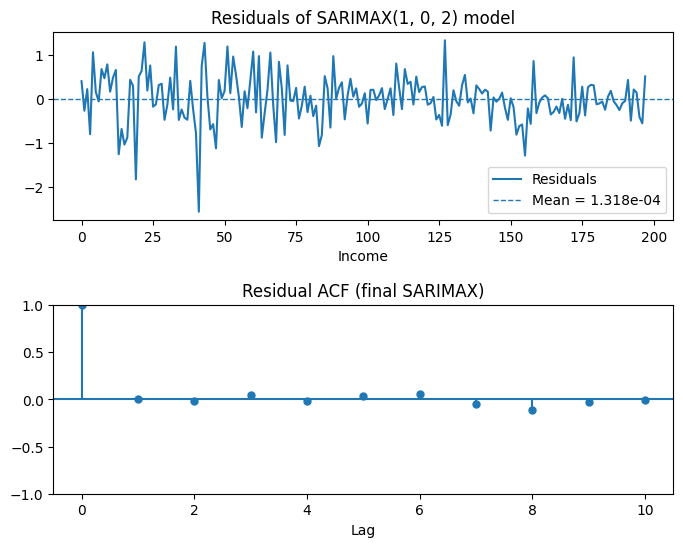

,lb_stat,lb_pvalue
10,4.592230,0.916703
20,12.959991,0.879094


In [296]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"hspace": 0.45})

mean_resid = np.mean(final_model.resid)

ax[0].plot(final_model.resid, label="Residuals")
ax[0].set_title("Residuals of SARIMAX(1, 0, 2) model")
ax[0].axhline(np.mean(mean_resid), linestyle="--", linewidth=1, label=f"Mean = {np.mean(mean_resid):.3e}")
ax[0].set_xlabel(x_name)
ax[0].legend()

plot_acf(final_model.resid, lags=10, ax=ax[1], alpha=None)
ax[1].set_title("Residual ACF (final SARIMAX)")
ax[1].set_xlabel("Lag")

plt.show()

acorr_ljungbox(final_model.resid, lags=[10,20], return_df=True)

The residuals have approximately zero mean, the ACF of the residuals shows no significant autocorrelation and the Ljung-Box test does not reject the null hypothesis of no autocorrelation at a 95% significance level.

- Compare $\beta$ from OLS vs SARIMAX: how did the estimate and/or standard error change, and why?

In [277]:
comparison = pd.DataFrame({
    "OLS": [ols_model.params[x_name], ols_model.bse[x_name]],
    "SARIMAX": [final_model.params[x_name], final_model.bse[x_name]]
}, index=["beta", "std_error"])

comparison

,OLS,SARIMAX
beta,0.271833,0.199226
std_error,0.046729,0.034226


The OLS model only captures structure in $\beta$ while the SARIMAX model captures structure in both $\beta$ and the ARMA model for the autocorrelated errors. As such it is expected that $\beta$ for the SARIMAX model is smaller. The standard error does not differ much between the models which might indicate that the autocorrelation in the errors is not large and that the SARIMAX model does not capture much more structure than the OLS model.